In [1]:
#@title Import Packages
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.15.0
The following GPU devices are available: 


# **Task 2**

In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [3]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [4]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):

  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)


# If the total height of the display strings added to the top of the bounding
# box exceeds the top of the image, stack the strings below the bounding box
# instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
# Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
# Reverse list and print from bottom to top.

  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin


In [5]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
#"""Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()


  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image( image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image

image_url = "https://m.media-amazon.com/images/I/81rYiyk2N+L.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

#to draw boxes
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

#pass the image to the detector
run_detector(detector, downloaded_image_path)

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-11-c054bbf0d261>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /tmp/tmpt09hhgxx.jpg.
Found 100 objects.
Inference time:  89.55390787124634


<ipython-input-11-c054bbf0d261>:61: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-11-c054bbf0d261>:72: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


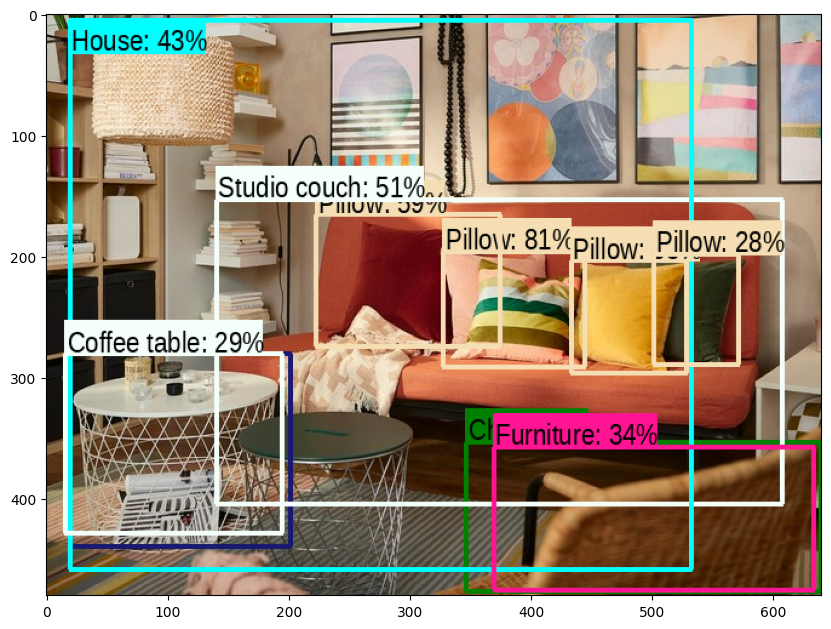

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageColor
import tempfile
from urllib.request import urlopen
from io import BytesIO

# Load the object detection model from TensorFlow Hub
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

def display_image(image):
    """Displays an image without a grid."""
    fig = plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.imshow(image)
    plt.show()

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    """Downloads an image from a URL and resizes it to the specified dimensions."""
    # Create a temporary file to save the image
    _, filename = tempfile.mkstemp(suffix=".jpg")

    # Open the URL and read the image data
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)

    # Open the image and resize it
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")

    # Save the image to the temporary file
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)

    # Optionally display the image
    if display:
        display_image(pil_image)

    # Return the filename of the downloaded image
    return filename

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size

    # Calculate the bounding box coordinates
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)

    # Draw the bounding box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    # Calculate the height of the display strings
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    # Determine the position for the text
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    # Draw each display string
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)

        # Draw a filled rectangle for the text background
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)

        # Draw the text
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    # Get a list of colors to use for the boxes
    colors = list(ImageColor.colormap.values())

    # Try to load a custom font, fall back to the default font if not found
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    # Draw the boxes on the image
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # Draw the bounding box with the display string
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])

            # Copy the image with the drawn box back to the original image
            np.copyto(image, np.array(image_pil))

    # Return the image with the boxes drawn
    return image

def run_detector(detector, path):
    """Runs the object detector on an image and displays the results."""
    # Load the image from the specified path
    img = load_img(path)

    # Convert the image to a float32 tensor and add a batch dimension
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # Run the detector on the image and measure the inference time
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # Convert the results to numpy arrays
    result = {key: value.numpy() for key, value in result.items()}

    # Print the number of objects detected and the inference time
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    # Draw bounding boxes on the image and display it
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"]
    )

    # Display the image with bounding boxes
    display_image(image_with_boxes)

def load_img(path):
    """Loads an image from a file path and decodes it into a tensor."""
    # Read the image file
    img = tf.io.read_file(path)
    # Decode the image as a JPEG and ensure it has 3 color channels
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def detect_img(image_url):
    """Downloads, resizes, and runs the detector on the image from the given URL."""
    image_path = download_and_resize_image(image_url, 640, 480, display=False)
    run_detector(detector, image_path)

# List of image URLs
image_urls = [
    "https://www.ikea.com/images/two-kvistbro-tables-in-different-sizes-sit-in-front-of-an-or-21155797afaa27afc593ab509c79f518.jpg?f=sg"
]

def process_images(image_urls):
    """Processes a list of image URLs, performing detection and displaying results."""
    for url in image_urls:
        detect_img(url)

# Process the images
process_images(image_urls)


In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageColor
import tempfile
from urllib.request import urlopen
from io import BytesIO
import os

# Load the object detection model from TensorFlow Hub
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

def display_image(image):
    """Displays an image without a grid."""
    fig = plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.imshow(image)
    plt.show()

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    """Downloads an image from a URL and resizes it to the specified dimensions."""
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)

    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)

    if display:
        display_image(pil_image)

    return filename

def resize_image(image_path, new_width=256, new_height=256, display=False):
    """Resizes an image from a file path to the specified dimensions."""
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    resized_path = os.path.splitext(image_path)[0] + "_resized.jpg"
    pil_image_rgb.save(resized_path, format="JPEG", quality=90)
    print("Image resized and saved to %s." % resized_path)

    if display:
        display_image(pil_image)

    return resized_path

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))

    return image

def run_detector(detector, path):
    """Runs the object detector on an image and displays the results."""
    img = load_img(path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key: value.numpy() for key, value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"]
    )

    display_image(image_with_boxes)

def load_img(path):
    """Loads an image from a file path and decodes it into a tensor."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def detect_img(image_source):
    """Handles both URL and local file image sources for detection."""
    if image_source.startswith("http"):
        image_path = download_and_resize_image(image_source, 640, 480, display=False)
    else:
        image_path = resize_image(image_source, 640, 480, display=False)

    run_detector(detector, image_path)

# List of image sources (URLs and local file paths)
image_sources = [
    "https://m.media-amazon.com/images/I/81rYiyk2N+L.jpg",
    "/content/work.jpg",
    "https://www.ikea.com/images/two-kvistbro-tables-in-different-sizes-sit-in-front-of-an-or-21155797afaa27afc593ab509c79f518.jpg?f=sg",
]

def process_images(image_sources):
    """Processes a list of image sources, performing detection and displaying results."""
    for source in image_sources:
        detect_img(source)

# Process the images
process_images(image_sources)


Output hidden; open in https://colab.research.google.com to view.